# 상위 5호가씩의 ordexe 데이터로 학습한 LSTM 모델
- 모델의 실행은 10분을 주기로 함.
- 

# (1) 라이브러리 import

In [1]:
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback

# (2) 데이터 불러오기
- 전처리를 완료한 ordexe_{날짜}.csv 파일을 불러온다. (총 53개의 열 보유)
- 전처리된 데이터들은 preprocessing 폴더 안에 있다.
- preprocessing 폴더 경로: C:\\Users\\lys17\\Downloads\\preprocessing

In [3]:
#현재 작업 디렉토리 확인
os.getcwd()

'C:\\Users\\lys17\\Downloads'

In [4]:
#시작 시간 기록
start_time = time.time()

#폴더 경로 및 파일 패턴 설정
folder_path = ".\\preprocessing"  #preprocessing 폴더 경로
file_pattern = os.path.join(folder_path, '*.csv')  #preprocessing 폴더 내 모든 CSV 파일의 패턴

#모든 CSV 파일을 리스트로 불러오기
file_list = glob.glob(file_pattern) #모든 csv파일의 경로를 문자열로 저장

#각 파일을 읽어서 데이터프레임 리스트에 저장 (로딩 바 추가)
df_list = []
for file in tqdm(file_list, desc="Loading CSV files"):
    df = pd.read_csv(file)
    df_list.append(df)

#데이터프레임을 하나로 합치기
combined_df = pd.concat(df_list, ignore_index=True)

#총 걸린 시간 계산 및 출력
end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

Loading CSV files: 100%|███████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]



Total time taken: 94.47 seconds


In [5]:
#9/23 ~ 10/28일까지 통합한 데이터프레임 확인
print(combined_df.head())
print(f"Total rows: {len(combined_df)}")

       timestamp  total_ask_size  total_bid_size  1_ask_price  1_bid_price  \
0  1727017200386        0.499237        0.925602   83658000.0   83622000.0   
1  1727017201586        0.501627        0.896695   83658000.0   83622000.0   
2  1727017201786        0.501627        0.861926   83658000.0   83625000.0   
3  1727017202086        0.500431        0.861926   83658000.0   83625000.0   
4  1727017202486        0.500431        0.878067   83658000.0   83625000.0   

   1_ask_size  1_bid_size  2_ask_price  2_bid_price  2_ask_size  2_bid_size  \
0    0.032215    0.005979   83670000.0   83621000.0    0.006364    0.016141   
1    0.032215    0.005979   83670000.0   83621000.0    0.006364    0.016141   
2    0.032215    0.000061   83670000.0   83622000.0    0.006364    0.005979   
3    0.031019    0.000061   83670000.0   83622000.0    0.006364    0.005979   
4    0.031019    0.000061   83670000.0   83622000.0    0.006364    0.005979   

   3_ask_price  3_bid_price  3_ask_size  3_bid_size  4_a

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987543 entries, 0 to 5987542
Data columns (total 53 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        int64  
 1   total_ask_size   float64
 2   total_bid_size   float64
 3   1_ask_price      float64
 4   1_bid_price      float64
 5   1_ask_size       float64
 6   1_bid_size       float64
 7   2_ask_price      float64
 8   2_bid_price      float64
 9   2_ask_size       float64
 10  2_bid_size       float64
 11  3_ask_price      float64
 12  3_bid_price      float64
 13  3_ask_size       float64
 14  3_bid_size       float64
 15  4_ask_price      float64
 16  4_bid_price      float64
 17  4_ask_size       float64
 18  4_bid_size       float64
 19  5_ask_price      float64
 20  5_bid_price      float64
 21  5_ask_size       float64
 22  5_bid_size       float64
 23  6_ask_price      float64
 24  6_bid_price      float64
 25  6_ask_size       float64
 26  6_bid_size       float64
 27  7_ask_price 

In [7]:
#필요한 열만 선택
#상위 5호가씩 사용
combined_df.drop([f'{i}_ask_price' for i in range(6, 11)] + [f'{i}_bid_price' for i in range(6, 11)] + [f'{i}_ask_size' for i in range(6, 11)] + [f'{i}_bid_size' for i in range(6, 11)], axis = 1, inplace = True)
combined_df.columns

Index(['timestamp', 'total_ask_size', 'total_bid_size', '1_ask_price',
       '1_bid_price', '1_ask_size', '1_bid_size', '2_ask_price', '2_bid_price',
       '2_ask_size', '2_bid_size', '3_ask_price', '3_bid_price', '3_ask_size',
       '3_bid_size', '4_ask_price', '4_bid_price', '4_ask_size', '4_bid_size',
       '5_ask_price', '5_bid_price', '5_ask_size', '5_bid_size', 'trade_price',
       'trade_volume', 'ask_bid', 'spread', 'imbalance', 'totalSize_ratio',
       'avgPrice_diff', 'ask_vwap', 'bid_vwap', 'cum_vp'],
      dtype='object')

# (3) 수치형 변수들의 상관관계 확인
heatmap을 통해 수치형 변수들 간의 상관관계를 살펴본다.

<Axes: >

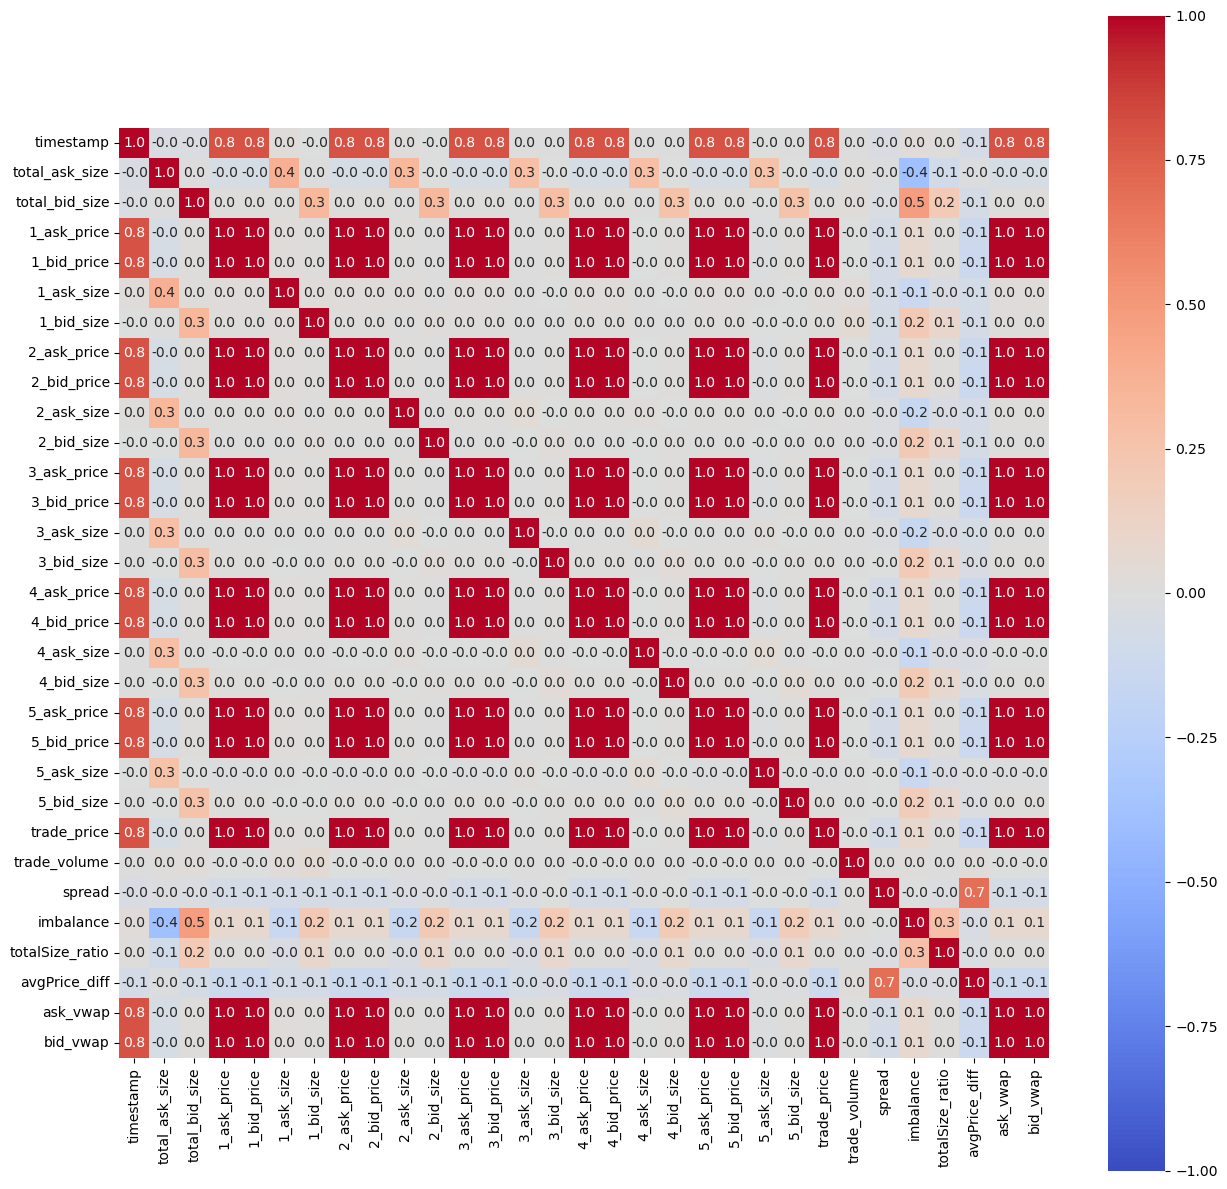

In [9]:
#상관계수 계산
corr_matrix = combined_df.drop(['ask_bid', 'cum_vp'], axis=1).corr() #ask_bid는 범주형이므로 제외, cum_vp는 초반에 inf값이 있으므로 제외

#heatmap 생성
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=True, square=True, fmt=".1f")
#vmin=-1 / vmax=1 / center=0: 0을 기준으로 음수는 파란색, 양수는 빨간색 계열로 표시

**Heatmap 해석**
1. (timestamp, i_ask_price), (timestamp, i_bid_price), (timestamp, trade_price), (timestamp, ask_vwap), (timestamp, bid_vwap)의 상관계수는 약 0.8 이다.
   - 시간이 지남에 따라 1~5 매도호가와 매수호가, 체결가, 거래량가중평균가는 유사한 방향으로 움직이는 경향이 강하다.
   - 즉, 시간이 흐르면서 모두 양의 방향으로 움직이는 경향을 보인다.
2. i_ask_price, i_bid_price, trade_price, ask_vwap, bid_vwap는 서로의 상관계수가 약 1.0이다.
   - 이들 중 하나만 선택해도 모델 학습에 무관할 것 같다.
   - 하나만 선택하게 된다면, y(타겟변수)가 될 trade_price를 선택해야 한다.
3. (spread, avgPrice_diff)는 상관계수가 약 0.7이다.
   - 둘 중 하나만 선택해도 모델 학습에 무관할 것 같다.
   - 두 파생변수는 의미가 비슷하므로 spread만 선택해도 될 것 같다.

**결론**
1. i_ask_price, i_bid_price, trade_price, ask_vwap, bid_vwap 중 trade_price만 선택한다.
2. spread와 avgPrice_dff 중에선 spread만 선택한다.
3. (임시) ask_bid는 모델 학습에 큰 영향을 줄 것 같지 않아서 제외한다.
4. (임시) cum_vp는 초반에 inf값 처리 문제로 일단 제외한다.

# (4) 변수 재정리

## (4-1) 불필요한 열 제거

In [14]:
#위 결론에 따라 불필요한 열 제거
combined_df.drop([f'{i}_ask_price' for i in range(1,6)] + [f'{i}_bid_price' for i in range(1,6)] + ["ask_vwap", "bid_vwap", "avgPrice_diff", "ask_bid", "cum_vp"], axis = 1, inplace = True)

In [15]:
combined_df.head()

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio
0,1727017200386,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.12224,0.063830,0.00012,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.658003,4.848005
1,1727017201586,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.12224,0.300359,0.00012,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.636619,4.503863
2,1727017201786,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.12224,0.016141,0.00012,0.300359,0.00102,0.080266,83658000.0,0.000100,33000.0,0.634520,4.472258
3,1727017202086,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.12224,0.016141,0.00012,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.636627,4.503981
4,1727017202486,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.12224,0.032282,0.00012,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.642842,4.599765


In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987543 entries, 0 to 5987542
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        int64  
 1   total_ask_size   float64
 2   total_bid_size   float64
 3   1_ask_size       float64
 4   1_bid_size       float64
 5   2_ask_size       float64
 6   2_bid_size       float64
 7   3_ask_size       float64
 8   3_bid_size       float64
 9   4_ask_size       float64
 10  4_bid_size       float64
 11  5_ask_size       float64
 12  5_bid_size       float64
 13  trade_price      float64
 14  trade_volume     float64
 15  spread           float64
 16  imbalance        float64
 17  totalSize_ratio  float64
dtypes: float64(17), int64(1)
memory usage: 822.3 MB


## (4-2) 종속변수(y) 생성
10분 후의 trade_price가 곧 종속변수인 y가 된다.

In [18]:
#10분 후의 timestamp를 계산하여 새 열 생성
combined_df['timestamp_10min_later'] = combined_df['timestamp'] + 600000 #10분 후 = +600,000

#원본 데이터프레임과 10분 후 timestamp 기준으로 가장 가까운 행을 병합
df_merged = pd.merge_asof(combined_df,
                          combined_df[['timestamp', 'trade_price']].rename(columns={'timestamp': 'nearest_timestamp', 'trade_price': 'nearest_trade_price'}),
                          left_on='timestamp_10min_later',
                          right_on='nearest_timestamp',
                          direction='forward') #10분 후 시점에 가장 가까운 다음 timestamp를 기준으로 병합 진행 (모델 run time 기준이 10분이니까 최소 10분은 지나야함)

#trade_price 비교하여 trade_price_10min_later 열 생성
df_merged['trade_price_10min_later'] = (df_merged['nearest_trade_price'] > df_merged['trade_price']).astype(int) #현재가(trade_price)보다 높으면 1, 아니면 0
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,timestamp_10min_later,nearest_timestamp,nearest_trade_price,trade_price_10min_later
0,1727017200386,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,36000.0,0.658003,4.848005,1727017800386,1.727018e+12,83682000.0,1
1,1727017201586,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.001020,0.142020,83658000.0,0.000100,36000.0,0.636619,4.503863,1727017801586,1.727018e+12,83682000.0,1
2,1727017201786,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,33000.0,0.634520,4.472258,1727017801786,1.727018e+12,83682000.0,1
3,1727017202086,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.636627,4.503981,1727017802086,1.727018e+12,83682000.0,1
4,1727017202486,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.642842,4.599765,1727017802486,1.727018e+12,83682000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987538,1730127597233,0.492522,1.289435,0.011355,0.006033,0.291486,0.002497,0.072650,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.418679,2.440437,1730128197233,NaN,NaN,0
5987539,1730127597633,0.428375,1.289435,0.011355,0.006033,0.291486,0.002497,0.008502,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.477321,2.826439,1730128197633,NaN,NaN,0
5987540,1730127598233,0.478621,1.289435,0.011355,0.006033,0.291486,0.002497,0.008502,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.416879,2.429822,1730128198233,NaN,NaN,0
5987541,1730127598733,0.501015,1.289054,0.011355,0.005653,0.291486,0.002497,0.013703,0.008502,0.000215,1.006868,0.072640,0.000217,96097000.0,0.000380,2000.0,0.411125,2.396304,1730128198733,NaN,NaN,0


▼ 하단 행들 중 몇 개는 10분 후의 timestamp가 데이터에 존재하지 않아 nearest_timestamp값을 계산하지 못하는 경우가 있다

In [20]:
#nearest_timestamp가 NaN인 경우 확인
df_merged.nearest_timestamp.isna().sum()

1190

In [21]:
#neareset_timestamp가 NaN인 행
df_merged[df_merged.nearest_timestamp.isna()]

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,timestamp_10min_later,nearest_timestamp,nearest_trade_price,trade_price_10min_later
5986353,1730126999413,2.904813,1.068375,0.046714,0.012691,0.486217,0.024640,0.298331,0.000200,0.659504,0.072440,0.990263,0.006471,96238000.0,0.010395,20000.0,-0.702431,0.174791,1730127599413,NaN,NaN,0
5986354,1730127000313,2.904813,1.013399,0.046714,0.004677,0.486217,0.012691,0.298331,0.024640,0.659504,0.000200,0.990263,0.072440,96238000.0,0.010395,19000.0,-0.708537,0.170592,1730127600313,NaN,NaN,0
5986355,1730127000613,2.904813,1.013399,0.046714,0.004677,0.486217,0.012691,0.298331,0.024640,0.659504,0.000200,0.990263,0.072440,96238000.0,0.010395,19000.0,-0.708537,0.170592,1730127600613,NaN,NaN,0
5986356,1730127001113,3.056115,1.013399,0.046714,0.004677,0.637520,0.012691,0.298331,0.024640,0.659504,0.000200,0.990263,0.072440,96238000.0,0.010395,19000.0,-0.721581,0.161723,1730127601113,NaN,NaN,0
5986357,1730127001713,3.053766,1.013399,0.044364,0.004677,0.637520,0.012691,0.298331,0.024640,0.659504,0.000200,0.990263,0.072440,96238000.0,0.002349,19000.0,-0.721387,0.161854,1730127601713,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987538,1730127597233,0.492522,1.289435,0.011355,0.006033,0.291486,0.002497,0.072650,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.418679,2.440437,1730128197233,NaN,NaN,0
5987539,1730127597633,0.428375,1.289435,0.011355,0.006033,0.291486,0.002497,0.008502,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.477321,2.826439,1730128197633,NaN,NaN,0
5987540,1730127598233,0.478621,1.289435,0.011355,0.006033,0.291486,0.002497,0.008502,0.008502,0.005201,1.006868,0.000215,0.000217,96099000.0,0.001041,2000.0,0.416879,2.429822,1730128198233,NaN,NaN,0
5987541,1730127598733,0.501015,1.289054,0.011355,0.005653,0.291486,0.002497,0.013703,0.008502,0.000215,1.006868,0.072640,0.000217,96097000.0,0.000380,2000.0,0.411125,2.396304,1730128198733,NaN,NaN,0


In [22]:
#nearest_timestamp가 NaN인 경우는 제거
df_merged = df_merged.dropna().reset_index(drop=True)
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,timestamp_10min_later,nearest_timestamp,nearest_trade_price,trade_price_10min_later
0,1727017200386,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,36000.0,0.658003,4.848005,1727017800386,1.727018e+12,83682000.0,1
1,1727017201586,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.001020,0.142020,83658000.0,0.000100,36000.0,0.636619,4.503863,1727017801586,1.727018e+12,83682000.0,1
2,1727017201786,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,33000.0,0.634520,4.472258,1727017801786,1.727018e+12,83682000.0,1
3,1727017202086,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.636627,4.503981,1727017802086,1.727018e+12,83682000.0,1
4,1727017202486,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.642842,4.599765,1727017802486,1.727018e+12,83682000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986348,1730126996013,2.895852,1.073478,0.042948,0.012691,0.486217,0.024640,0.293135,0.072440,0.659504,0.006471,0.990263,0.148616,96238000.0,0.000829,20000.0,-0.567196,0.276165,1730127596013,1.730128e+12,96100000.0,0
5986349,1730126996913,2.894194,1.073478,0.041290,0.012691,0.486217,0.024640,0.293135,0.072440,0.659504,0.006471,0.990263,0.148616,96238000.0,0.001658,20000.0,-0.566991,0.276331,1730127596913,1.730128e+12,96099000.0,0
5986350,1730126997613,2.899389,1.068375,0.046486,0.012691,0.486217,0.024640,0.293135,0.000200,0.659504,0.072440,0.990263,0.006471,96238000.0,0.001658,20000.0,-0.701932,0.175135,1730127597613,1.730128e+12,96099000.0,0
5986351,1730126997713,2.910013,1.068375,0.057109,0.012691,0.486217,0.024640,0.293135,0.000200,0.659504,0.072440,0.990263,0.006471,96238000.0,0.001658,20000.0,-0.702908,0.174462,1730127597713,1.730128e+12,96099000.0,0


In [23]:
#불필요한 열 제거
df_merged.index = df_merged['timestamp'] #timestamp를 index로 지정
df_merged.drop(['timestamp', 'timestamp_10min_later', 'nearest_timestamp', 'nearest_trade_price'], axis=1, inplace=True)

In [24]:
df_merged.columns

Index(['total_ask_size', 'total_bid_size', '1_ask_size', '1_bid_size',
       '2_ask_size', '2_bid_size', '3_ask_size', '3_bid_size', '4_ask_size',
       '4_bid_size', '5_ask_size', '5_bid_size', 'trade_price', 'trade_volume',
       'spread', 'imbalance', 'totalSize_ratio', 'trade_price_10min_later'],
      dtype='object')

In [25]:
#모델링 전 최종 데이터프레임을 csv파일로 저장
df_merged.to_csv('final_data.csv', index=False)

In [55]:
df_merged["trade_price_10min_later"]

timestamp
1727017200386    1
1727017201586    1
1727017201786    1
1727017202086    1
1727017202486    1
                ..
1730126996013    0
1730126996913    0
1730126997613    0
1730126997713    0
1730126998113    0
Name: trade_price_10min_later, Length: 5986353, dtype: int32

In [51]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5986353 entries, 1727017200386 to 1730126998113
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   total_ask_size           float64
 1   total_bid_size           float64
 2   1_ask_size               float64
 3   1_bid_size               float64
 4   2_ask_size               float64
 5   2_bid_size               float64
 6   3_ask_size               float64
 7   3_bid_size               float64
 8   4_ask_size               float64
 9   4_bid_size               float64
 10  5_ask_size               float64
 11  5_bid_size               float64
 12  trade_price              float64
 13  trade_volume             float64
 14  spread                   float64
 15  imbalance                float64
 16  totalSize_ratio          float64
 17  trade_price_10min_later  int32  
dtypes: float64(17), int32(1)
memory usage: 844.9 MB


# (5) LSTM 모델 학습

## (5-1) X(독립변수), y(종속변수) 데이터셋 분리

In [17]:
#데이터 준비
df = df_merged.copy()

#X와 y 데이터셋 분리
X = df.drop(columns=['trade_price_10min_later']).values
y = df['trade_price_10min_later'].values #trade_price_10min_later가 target

## (5-2) 데이터 스케일링
변수들의 단위(scale)가 각각 다르므로 표준화를 시켜준다.

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.83970395, -0.47916167, -0.24206646, ...,  0.62393175,
         1.65643757,  0.37191828],
       [-0.83885299, -0.49232116, -0.24206646, ...,  0.62393175,
         1.61298039,  0.33100242],
       [-0.83885299, -0.50814929, -0.24206646, ...,  0.49482269,
         1.60871529,  0.32724475],
       ...,
       [ 0.01487833, -0.41416574, -0.22858168, ..., -0.0646499 ,
        -1.10724542, -0.18365127],
       [ 0.01866088, -0.41416574, -0.21854347, ..., -0.0646499 ,
        -1.10922769, -0.1837313 ],
       [ 0.01495956, -0.41416574, -0.22836611, ..., -0.0646499 ,
        -1.10728813, -0.183653  ]])

## (5-3) 시계열 데이터 형식으로 변환

In [19]:
timesteps = 10 #10개 행씩 묶어서 진행 (이 부분은 hyper-parameter로 조정 가능)
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps]) #현재부터 다음 10개까지 데이터를 슬라이싱하여 한 묶음으로
    y_sequences.append(y[i+timesteps])

#dtype을 float64 -> float32로 변경 (메모리 문제 방지를 위해)
#float32는 소수점 7자리까지 보장
X_sequences = np.array(X_sequences, dtype=np.float32) #10개 시점의 X 데이터
y_sequences = np.array(y_sequences, dtype=np.float32) #그 다음 시점의 y값

In [20]:
print(f'X_sequences 차원: {X_sequences.shape}')
print(f'y_sequences 차원: {y_sequences.shape}')

X_sequences 차원: (5986343, 10, 17)
y_sequences 차원: (5986343,)


## (5-4) train, test 분리

In [21]:
#시퀀스 데이터의 train, test 분리는 시간 패턴에 따른 과적합 방지를 위해 비시계열성 데이터처럼 섞어서 진행해야 함
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42) #8:2 분리

#차원 확인
print(f'X_train 차원: {X_train.shape}')
print(f'y_train 차원: {y_train.shape}')
print(f'X_test 차원: {X_test.shape}')
print(f'y_test 차원: {y_test.shape}')

X_train 차원: (4789074, 10, 17)
y_train 차원: (4789074,)
X_test 차원: (1197269, 10, 17)
y_test 차원: (1197269,)


## (5-5) LSTM 모델 학습 및 평가

Training Progress:   0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5175

Training Progress:  10%|███▏                            | 1/10 [25:36<3:50:31, 1536.84s/it, loss=0.693, val_loss=0.691]

74830/74830 [==============================] - 1537s 20ms/step - loss: 0.6927 - accuracy: 0.5175 - val_loss: 0.6911 - val_accuracy: 0.5251
Epoch 2/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5343

Training Progress:  20%|██████▍                         | 2/10 [51:09<3:24:33, 1534.24s/it, loss=0.689, val_loss=0.686]

74830/74830 [==============================] - 1532s 20ms/step - loss: 0.6892 - accuracy: 0.5343 - val_loss: 0.6861 - val_accuracy: 0.5422
Epoch 3/10
74828/74830 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5507

Training Progress:  30%|█████████▎                     | 3/10 [1:17:04<3:00:06, 1543.78s/it, loss=0.684, val_loss=0.68]

74830/74830 [==============================] - 1555s 21ms/step - loss: 0.6838 - accuracy: 0.5507 - val_loss: 0.6797 - val_accuracy: 0.5604
Epoch 4/10
74829/74830 [============================>.] - ETA: 0s - loss: 0.6772 - accuracy: 0.5644

Training Progress:  40%|████████████                  | 4/10 [1:43:10<2:35:15, 1552.55s/it, loss=0.677, val_loss=0.671]

74830/74830 [==============================] - 1566s 21ms/step - loss: 0.6772 - accuracy: 0.5644 - val_loss: 0.6711 - val_accuracy: 0.5741
Epoch 5/10
74829/74830 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.5781

Training Progress:  50%|███████████████               | 5/10 [2:09:20<2:09:54, 1558.86s/it, loss=0.669, val_loss=0.664]

74830/74830 [==============================] - 1570s 21ms/step - loss: 0.6693 - accuracy: 0.5781 - val_loss: 0.6643 - val_accuracy: 0.5853
Epoch 6/10
74830/74830 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.5900

Training Progress:  60%|██████████████████            | 6/10 [2:35:23<1:44:01, 1560.36s/it, loss=0.662, val_loss=0.657]

74830/74830 [==============================] - 1563s 21ms/step - loss: 0.6616 - accuracy: 0.5900 - val_loss: 0.6570 - val_accuracy: 0.5954
Epoch 7/10
74828/74830 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.5986

Training Progress:  70%|█████████████████████         | 7/10 [3:01:17<1:17:54, 1558.22s/it, loss=0.656, val_loss=0.651]

74830/74830 [==============================] - 1554s 21ms/step - loss: 0.6556 - accuracy: 0.5986 - val_loss: 0.6510 - val_accuracy: 0.6028
Epoch 8/10
74828/74830 [============================>.] - ETA: 0s - loss: 0.6492 - accuracy: 0.6066

Training Progress:  80%|█████████████████████████▌      | 8/10 [3:27:08<51:52, 1556.05s/it, loss=0.649, val_loss=0.644]

74830/74830 [==============================] - 1551s 21ms/step - loss: 0.6492 - accuracy: 0.6066 - val_loss: 0.6439 - val_accuracy: 0.6093
Epoch 9/10
74829/74830 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.6133

Training Progress:  90%|████████████████████████████▊   | 9/10 [3:53:06<25:56, 1556.59s/it, loss=0.644, val_loss=0.642]

74830/74830 [==============================] - 1558s 21ms/step - loss: 0.6437 - accuracy: 0.6133 - val_loss: 0.6415 - val_accuracy: 0.6150
Epoch 10/10
74828/74830 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.6183

Training Progress: 100%|███████████████████████████████| 10/10 [4:19:01<00:00, 1556.00s/it, loss=0.639, val_loss=0.635]

74830/74830 [==============================] - 1555s 21ms/step - loss: 0.6392 - accuracy: 0.6183 - val_loss: 0.6348 - val_accuracy: 0.6204


Training Progress: 100%|███████████████████████████████| 10/10 [4:19:01<00:00, 1554.14s/it, loss=0.639, val_loss=0.635]


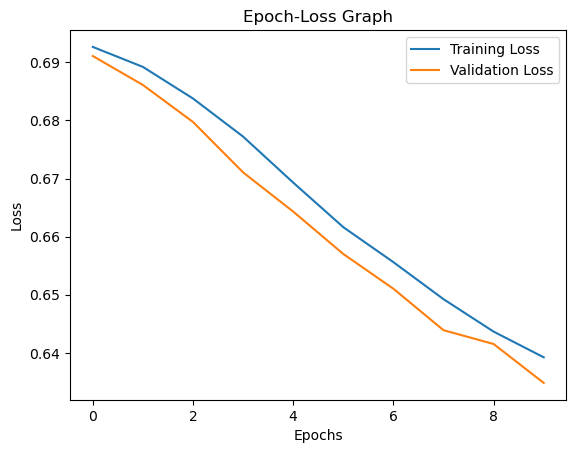

In [22]:
# #LSTM 모델 구성 (1st version)
# model = Sequential([

#     #[첫 번째 LSTM층]
#     LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.3), #과대적합 방지를 위한 dropout

#     #[두 번째 LSTM층]
#     LSTM(32, return_sequences=True)
#     BatchNormalization(),
#     Dropout(0.3),

#     #[세 번째 LSTM층]
#     LSTM(16, return_sequences=False), #이 층의 마지막 시점만 반환하여 다음층으로 전달
#     BatchNormalization(),
#     Dropout(0.3),

#     #[출력층]
#     Dense(1, activation='sigmoid') #이진 분류 문제이므로 활성화함수로 sigmoid 사용
# ])

#LSTM 모델 구성 (2nd version)
model = Sequential([

    #[첫 번째: LSTM층]
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    #50개의 유닛을 가진 LSTM층
    #timestamp 10개와 feature 17개의 input 형상 지정
    #다음 층으로 모든 timestamp의 출력을 전달
    BatchNormalization(),
    Dropout(0.3), #과대적합 방지를 위한 dropout

    #[두 번째: LSTM층]
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    #[세 번째: LSTM층]
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    #[네 번째: Dense층]
    Dense(32, activation="relu"),
    Dropout(0.3),

    #[출력층]
    Dense(1, activation='sigmoid')
])


#모델 compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#학습 진행을 표시하기 위한 Callback 설정
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
        self.tqdm.set_postfix(loss=logs['loss'], val_loss=logs['val_loss'])

    def on_train_end(self, logs=None):
        self.tqdm.close()

#학습 과정 시각화 및 히스토리 저장
tqdm_callback = TQDMProgressBar()
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[tqdm_callback])

# Epoch-Loss 그래프 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

37415/37415 [==============================] - 186s 5ms/step - loss: 0.6348 - accuracy: 0.6204
Test Loss: 0.6348, Test Accuracy: 0.6204
37415/37415 [==============================] - 184s 5ms/step


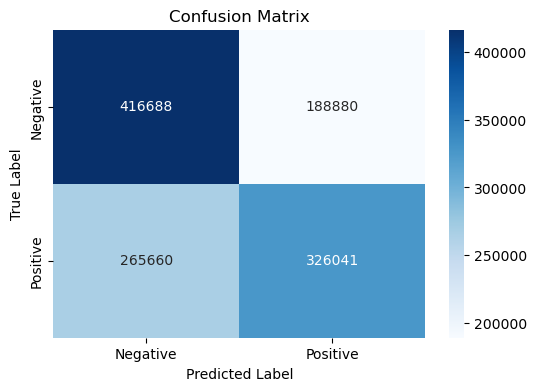

              precision    recall  f1-score   support

    Negative       0.61      0.69      0.65    605568
    Positive       0.63      0.55      0.59    591701

    accuracy                           0.62   1197269
   macro avg       0.62      0.62      0.62   1197269
weighted avg       0.62      0.62      0.62   1197269



In [23]:
# 테스트 데이터 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 예측값 생성
y_pred = (model.predict(X_test) > 0.5).astype(int)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 정밀도, 재현율, F1-스코어 출력
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [24]:
#모델 예측값
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [25]:
#예측값을 확률 형태로
model.predict(X_test)

37415/37415 [==============================] - 195s 5ms/step


array([[0.3542189 ],
       [0.48465624],
       [0.48469716],
       ...,
       [0.44717732],
       [0.3086126 ],
       [0.859947  ]], dtype=float32)

In [26]:
df_merged["trade_price_10min_later"].value_counts()

trade_price_10min_later
0    3026092
1    2960261
Name: count, dtype: int64

In [27]:
from sklearn.metrics import accuracy_score

y_pred_baseline = [0] + list(y_test[:-1])

#정확도 계산
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline Accuracy (Last Train Value): {baseline_accuracy:.4f}')

Baseline Accuracy (Last Train Value): 0.5008


# (6) 모델 저장

In [28]:
#모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           74752     
                                                                 
 batch_normalization (BatchN  (None, 10, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0

In [29]:
#모델 저장
model.save("lstm_5.h5")